In [10]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# telegram
import telegram

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 
from sklearn.covariance import EllipticEnvelope

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import os
import sys
import datetime
import time
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Code for info dataframe reset 

In [11]:
cols = ['Model', 'Set', 'Class','Phone','XPred','YPred','X','Y','rmse','euc','XErr','YErr']
df_ = pd.DataFrame(columns=cols)
df_.to_pickle(str(Path.home())+"/data/model_info.pkl")

In [12]:
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth=True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.2

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [29]:
! ls -l ~/data/models/IMU_N6_20190129_120835* | tail -n 1

-rw-r--r-- 1 stunkymonkey stunkymonkey 1930960 Jan 29 13:27 /home/beneste/data/models/IMU_N6_20190129_120835.0819-44287.66.h5


In [14]:
model_name = "IMU_general_20190131_132417.1480-0.02.h5"
ID = model_name.split(".")[0]

directory = str(Path.home()) + "/data/plots/" + ID

if not os.path.exists(directory):
    print("Making directory: " + directory)
    os.makedirs(directory)

In [15]:
smartphones = ["S3Mini", "S4", "N5X", "N6"]

In [16]:
###############################################
#Returns screen width, height, pixel size (mm)#
###############################################
def get_screen_size(device):
    return {
        'S3Mini' : np.array([480, 800, 0.1089]),
        'S4' : np.array([1080, 1920, 0.0577]), 
        'N5X': np.array([1080, 1920, 0.06]),
        'N6' : np.array([1440, 2560, 0.05109])
    }.get(device, None)

def normalizeWidth(row):
    smartphone = row.Phone
    return row.XPress / get_screen_size(smartphone)[0]

def normalizeHeight(row):
    smartphone = row.Phone    
    return row.YPress / get_screen_size(smartphone)[1]

########################
#Metrics for evaluation#
########################
def euc(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

####################################
#Metrics for dataframe calculations#
####################################
def calculate_eucMM(row):
    return math.sqrt((row['XPred'] - row['X'])**2 + (row['YPred'] - row['Y'])**2) * smartphone_values[2]

def calculate_rmseMM(row):
    return math.sqrt(mean_squared_error((row['X'],row['Y']), (row['XPred'],row['YPred']))) * smartphone_values[2]    

def calculate_x_error(row):
    return (row["XPred"] - row["X"]) * smartphone_values[2]

def calculate_y_error(row):
    return (row["YPred"] - row["Y"]) * smartphone_values[2]

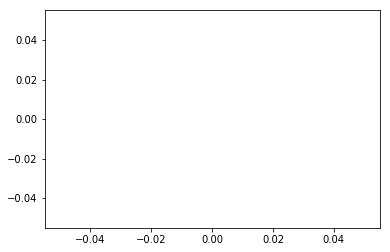

In [17]:
#####################
#Patches for legends#
#####################
colors = ["#fc8d59","#3182bd"]
texts = ["Test","Training"]
colors_predic = ["#91cf60","#fc8d59"]
texts_predic = ["Actual","Prediction"]

patches_origin_double = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

patches_origin = [plt.plot([], marker="o", ms=10, ls="", mec=None, color=colors[0], 
            label="{:s}".format(texts[0]) )[0]]

patches_predic = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors_predic[i], 
            label="{:s}".format(texts_predic[i]) )[0]  for i in range(len(texts))] 
patches_predic = patches_predic + plt.plot([], marker="_", ms=10, ls="", mec=None, color="#3182bd", label="Relation") 

Start processing: S3Mini
Start predicition for: S3Mini
Writing info pickle.
Start processing: S4
Start predicition for: S4
Writing info pickle.
Start processing: N5X
Start predicition for: N5X
Writing info pickle.
Start processing: N6
Start predicition for: N6
Writing info pickle.
CPU times: user 49.6 s, sys: 1.88 s, total: 51.5 s
Wall time: 49.7 s


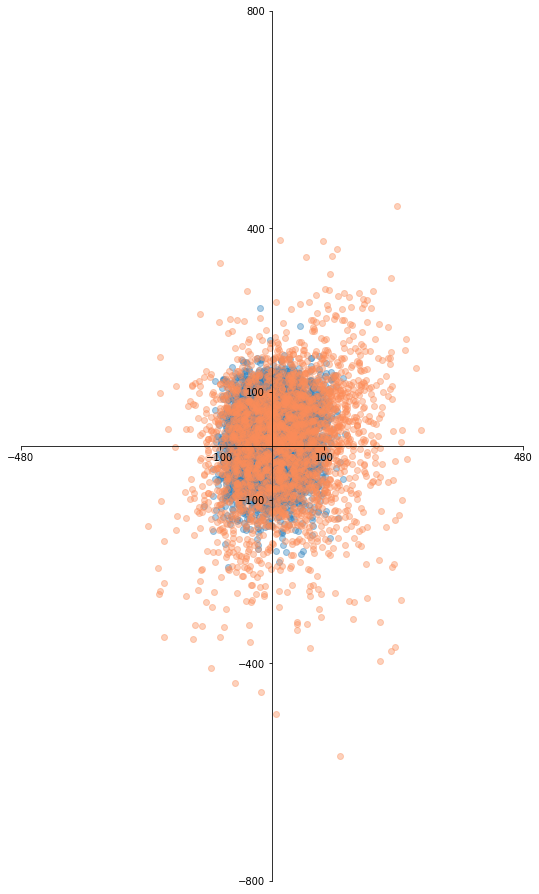

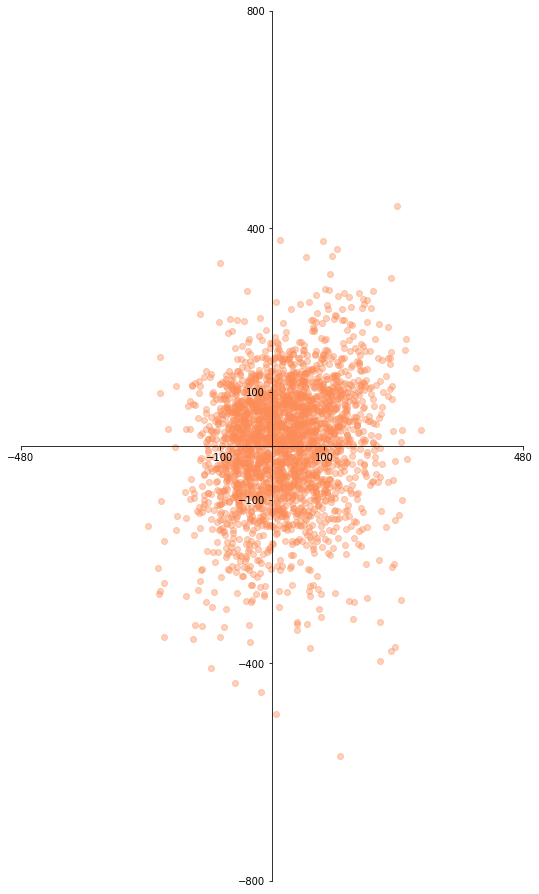

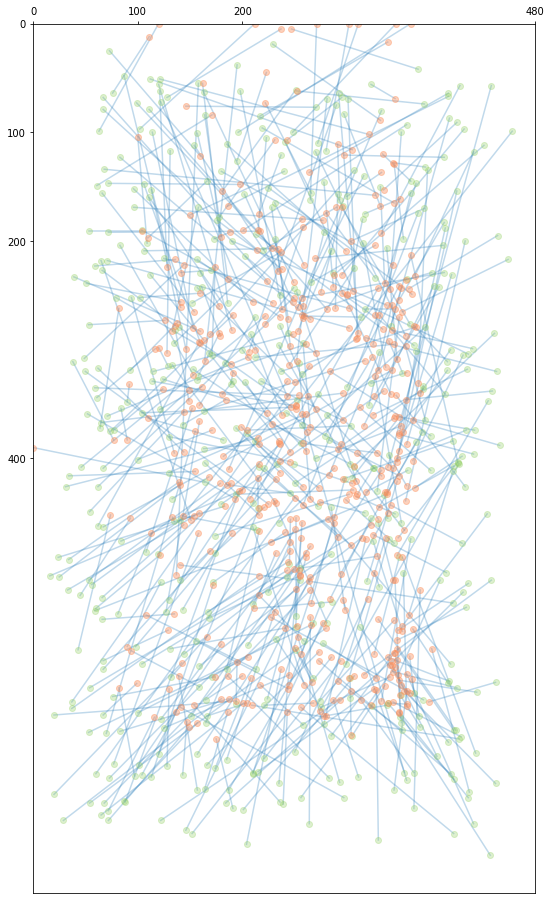

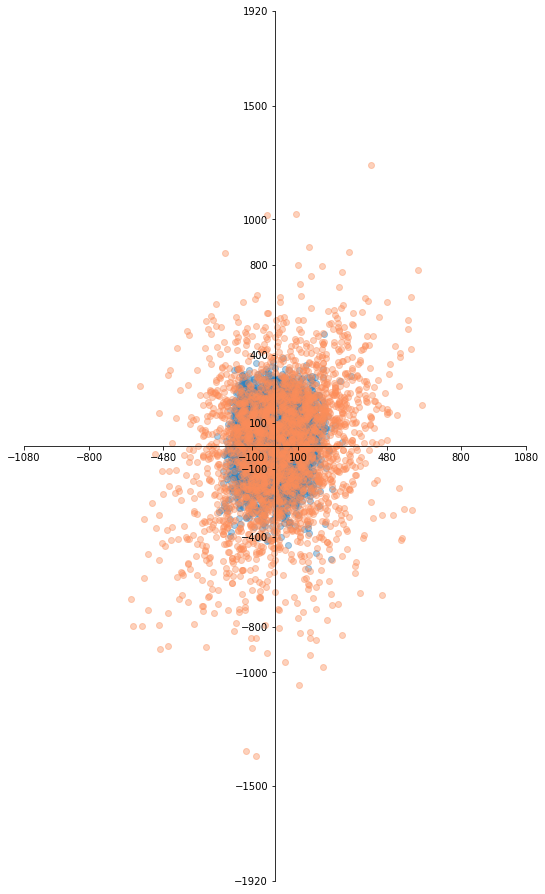

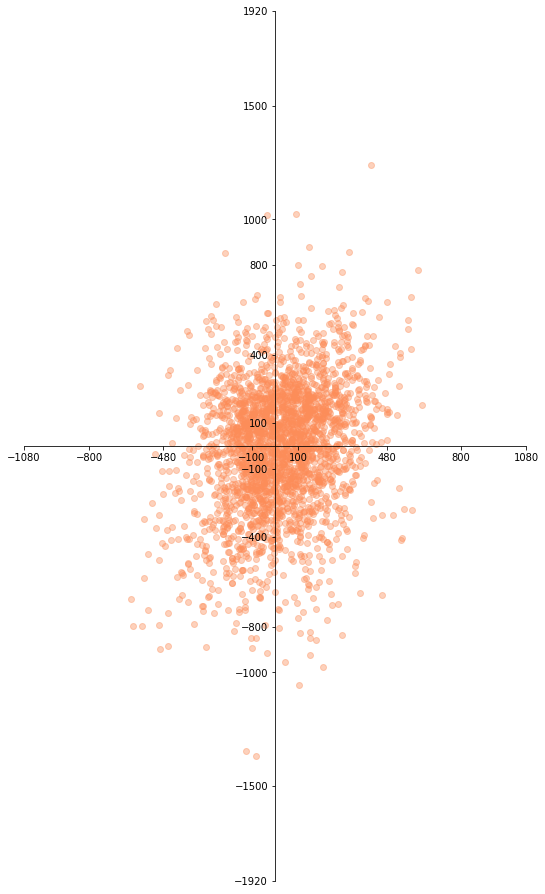

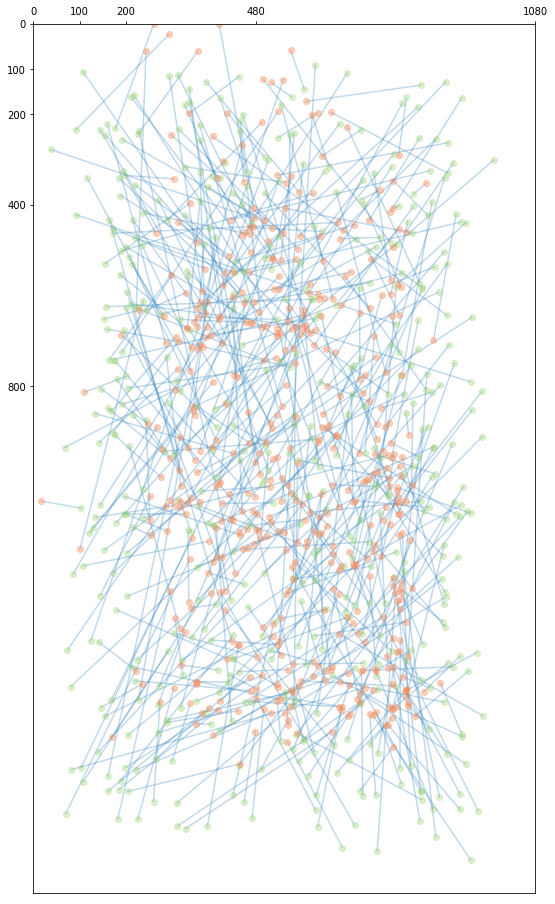

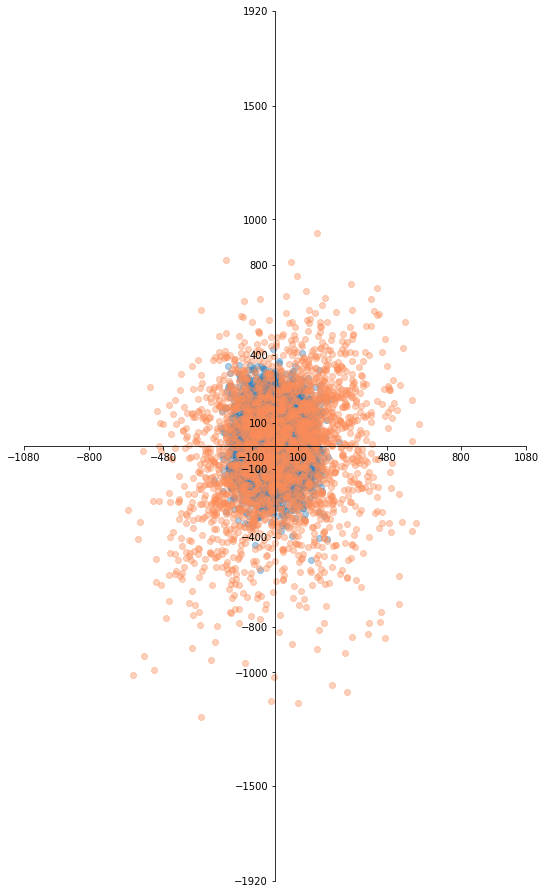

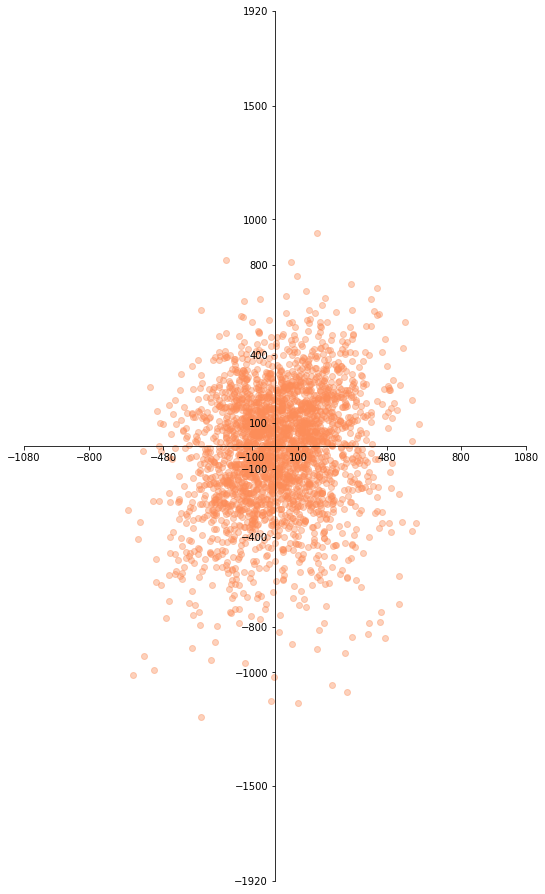

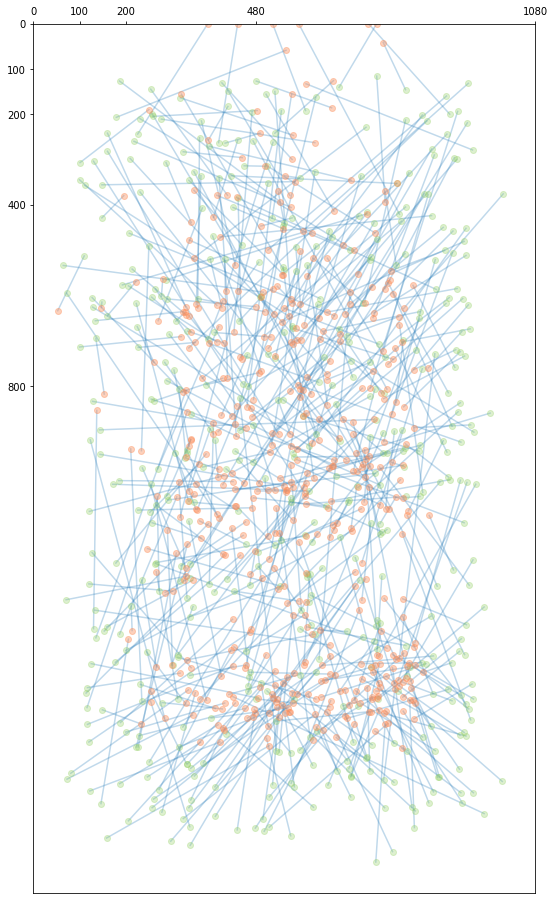

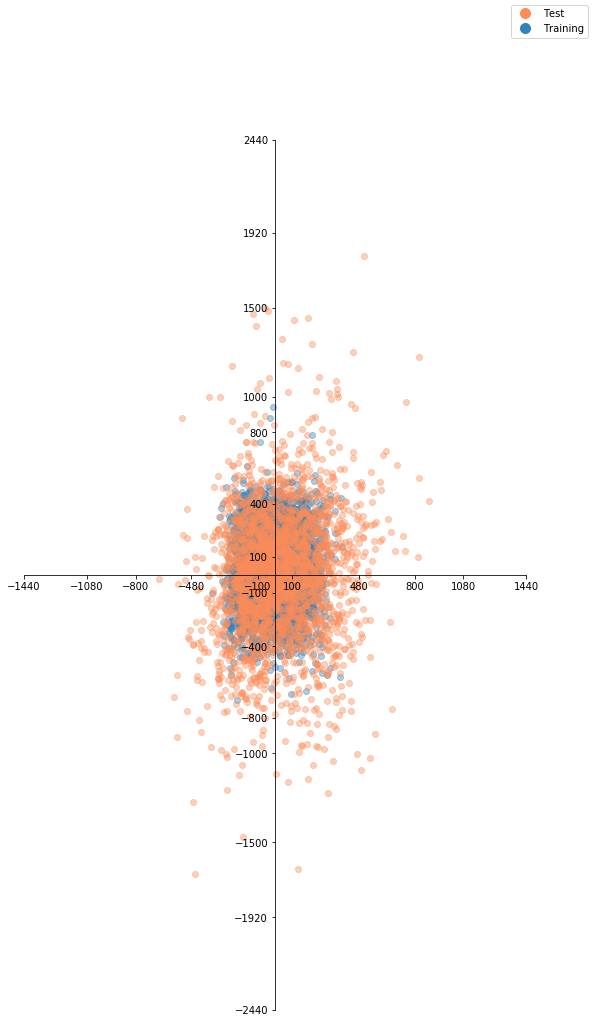

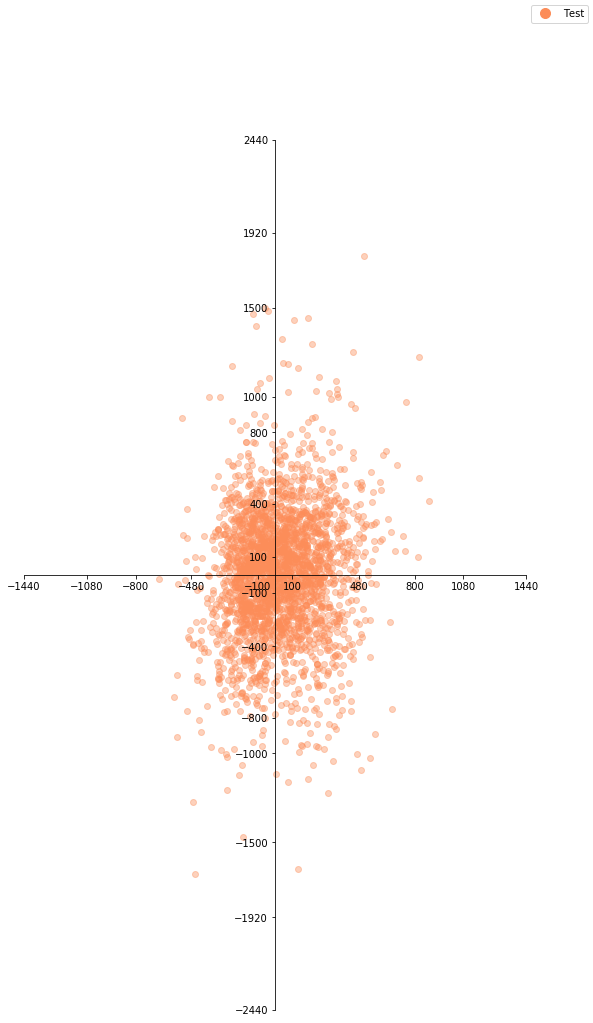

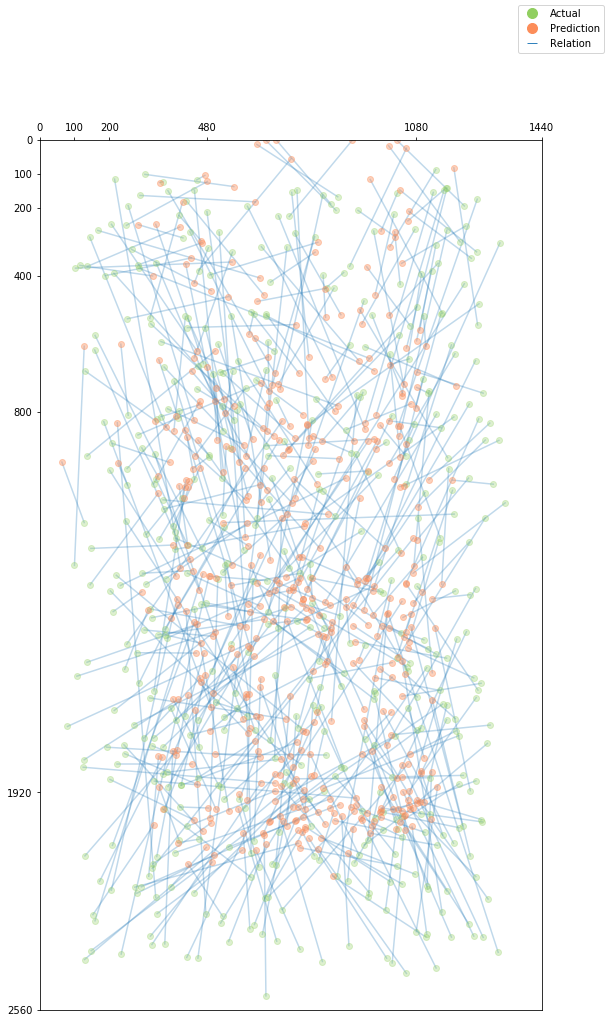

In [18]:
%%time

fig_origin_d = []
fig_origin_test = []
fig_pred_test = [] 

ax_origin_d = []
ax_origin_test = []
ax_pred_test = []

for i in range(0,4):
    #figures and axis for double origin plots
    fig1, ax1 = plt.subplots(1, figsize=(9,16))
    fig_origin_d.append(fig1)
    ax_origin_d.append(ax1)
    
    #figures and axis for origin plots
    fig1, ax1 = plt.subplots(1, figsize=(9,16))
    fig_origin_test.append(fig1)
    ax_origin_test.append(ax1)
    
    #figures and axis for predicition plots
    fig1, ax1 = plt.subplots(1, figsize=(9,16))
    fig_pred_test.append(fig1)
    ax_pred_test.append(ax1)

batch_size = 400
df = pd.read_pickle("../../data/step03.pkl")
model_path = str(Path.home()) + "/data/models/" + model_name
export_path = str(Path.home())+"/data/plots/" + ID

plotLegend = False

for s, smartphone in enumerate(smartphones):
    print("Start processing: " + smartphone)
    smartphone_values = get_screen_size(smartphone)
    
    if s == 3:
        plotLegend = True
          
    #df.Sensor = df.Sensor.apply(lambda x: x[-80:-20])
    df_temp = df[(df.Phone == smartphone)].copy(deep = True)

    ###################################################
    #Normalize X and Y labels and shuffle participants#
    ###################################################
    df_temp.XPress = df_temp.apply(lambda x: normalizeWidth(x), axis=1)
    df_temp.YPress = df_temp.apply(lambda x: normalizeHeight(x), axis=1)
    df_temp.Sensor = df_temp.Sensor.apply(lambda x: x.reshape(-1, 6, 1))

    np.random.seed(42)
    lst = df_temp.PId.unique()
    np.random.shuffle(lst)

    shape = df_temp.Sensor.iloc[0].shape
    
    ####################################################
    #Generate both training and test set for validation#
    ####################################################
    dfTrain = df_temp[df_temp.PId.isin(lst[:14])]
    dfTest = df_temp[df_temp.PId.isin(lst[14:])]

    train_x = np.concatenate(dfTrain.Sensor.values).reshape(-1, shape[0], shape[1], shape[2])
    train_y = dfTrain[['XPress', 'YPress']].values
    test_x = np.concatenate(dfTest.Sensor.values).reshape(-1, shape[0], shape[1], shape[2])
    test_y = dfTest[['XPress', 'YPress']].values

    #############################################################
    #Add zeros to dataset to make length dividable by batch size#
    #############################################################
    test_offset = batch_size - (len(test_x) % batch_size)
    test_x_zeros = np.zeros((test_offset, 100, 6, 1))
    test_y_zeros = np.zeros((test_offset, 2), dtype = int)
    test_y = np.concatenate([test_y, test_y_zeros])
    test_x = np.concatenate([test_x, test_x_zeros])

    train_offset = batch_size - (len(train_x) % batch_size)
    train_x_zeros = np.zeros((train_offset, 100, 6, 1))
    train_y_zeros = np.zeros((train_offset, 2), dtype = int)
    train_y = np.concatenate([train_y, train_y_zeros])
    train_x = np.concatenate([train_x, train_x_zeros])
    ##################################################################################
    #Load the model, predict with it, generate both train and test prediction history#
    ##################################################################################
    print("Start predicition for: " + smartphone)
    tf.get_default_graph()
    model = load_model(model_path, custom_objects={'euc':euc, 'rmse':rmse})

    optimizer = optimizers.Adam(lr = 0.001, decay = 1e-6)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', euc, rmse])
   
    hist_test = model.predict(test_x, batch_size=batch_size, verbose=0, steps=None)
    hist_train = model.predict(train_x, batch_size=batch_size, verbose=0, steps=None)

    #############################################################################
    #Generate DATAFRAMES with all predicitions from training and test validation#
    #These are used later for filling the model information dataframe 
    #############################################################################
    df_train = pd.DataFrame(np.concatenate([hist_train[:-train_offset], train_y[:-train_offset]], axis = 1), 
                            columns = ["XPred","YPred", "X", "Y"])
    df_test = pd.DataFrame(np.concatenate([hist_test[:-test_offset], test_y[:-test_offset]], axis = 1), 
                           columns = ["XPred","YPred", "X", "Y"])

    ####################
    #Undo normalization#
    ####################
    df_train.XPred = df_train.XPred * smartphone_values[0]
    df_train.YPred = df_train.YPred * smartphone_values[1]
    df_train.X = df_train.X * smartphone_values[0]
    df_train.Y = df_train.Y * smartphone_values[1]
    
    df_test.XPred = df_test.XPred * smartphone_values[0]
    df_test.YPred = df_test.YPred * smartphone_values[1]
    df_test.X = df_test.X * smartphone_values[0]
    df_test.Y = df_test.Y * smartphone_values[1]

    ###############################
    #Change column type to integer#
    ###############################
    df_train.XPred = df_train.XPred.astype(int) 
    df_train.YPred = df_train.YPred.astype(int)
    df_train.X = df_train.X.astype(int)
    df_train.Y = df_train.Y.astype(int)

    df_test.XPred = df_test.XPred.astype(int)
    df_test.YPred = df_test.YPred.astype(int)
    df_test.X = df_test.X.astype(int)
    df_test.Y = df_test.Y.astype(int)

    ####################
    #DOUBLE ORIGIN PLOT#
    ####################
    xticks = [-1440, -1080, -800, -480, -100, 100, 480, 800, 1080, 1440]
    yticks = [-2440, -1920, -1500, -1000, -800, -400, -100, 100, 400, 800, 1000, 1500, 1920, 2440]
    if "S3Mini" in smartphone:
        ax_origin_d[s].set_xticks(xticks[3:-3])
        ax_origin_d[s].set_yticks(yticks[4:-4])
        ax_origin_d[s].set_xlim(xticks[3], xticks[-4])
        ax_origin_d[s].set_ylim(yticks[4], yticks[-5])
    elif "N6" in smartphone:
        ax_origin_d[s].set_xticks(xticks[:])
        ax_origin_d[s].set_yticks(yticks[:])
        ax_origin_d[s].set_xlim(xticks[0], xticks[-1])
        ax_origin_d[s].set_ylim(yticks[0], yticks[-1])
    else:
        ax_origin_d[s].set_xticks(xticks[1:-1])
        ax_origin_d[s].set_yticks(yticks[1:-1])
        ax_origin_d[s].set_xlim(xticks[1],xticks[-2])
        ax_origin_d[s].set_ylim(yticks[1],yticks[-2])
    
    ax_origin_d[s].spines['right'].set_color('none')
    ax_origin_d[s].spines['top'].set_color('none')
    ax_origin_d[s].spines['left'].set_position(('data',0))
    ax_origin_d[s].spines['bottom'].set_position(('data',0))

    df_train["x_val"] = df_train.XPred - df_train.X
    df_train["y_val"] = df_train.YPred - df_train.Y
    ax_origin_d[s].scatter(df_train.x_val, -df_train.y_val, c = '#3182bd', alpha = 0.4)

    df_test["x_val"] = df_test.XPred - df_test.X
    df_test["y_val"] = df_test.YPred - df_test.Y
    ax_origin_d[s].scatter(df_test.x_val, -df_test.y_val, c = '#fc8d59', alpha = 0.4)

    if (plotLegend):
        fig_origin_d[s].legend(handles=patches_origin_double, loc='upper right', ncol=1, numpoints=1)

    ##################
    #TEST ORIGIN PLOT#
    ##################
    if "S3Mini" in smartphone:
        ax_origin_test[s].set_xticks(xticks[3:-3])
        ax_origin_test[s].set_yticks(yticks[4:-4])
        ax_origin_test[s].set_xlim(xticks[3], xticks[-4])
        ax_origin_test[s].set_ylim(yticks[4], yticks[-5])
    elif "N6" in smartphone:
        ax_origin_test[s].set_xticks(xticks[:])
        ax_origin_test[s].set_yticks(yticks[:])
        ax_origin_test[s].set_xlim(xticks[0], xticks[-1])
        ax_origin_test[s].set_ylim(yticks[0], yticks[-1])
    else:
        ax_origin_test[s].set_xticks(xticks[1:-1])
        ax_origin_test[s].set_yticks(yticks[1:-1])
        ax_origin_test[s].set_xlim(xticks[1],xticks[-2])
        ax_origin_test[s].set_ylim(yticks[1],yticks[-2])
        
    ax_origin_test[s].spines['right'].set_color('none')
    ax_origin_test[s].spines['top'].set_color('none')
    ax_origin_test[s].spines['left'].set_position(('data',0))
    ax_origin_test[s].spines['bottom'].set_position(('data',0))
    
    ax_origin_test[s].scatter(df_test.x_val, -df_test.y_val, c = '#fc8d59', alpha = 0.4)
    
    
    if (plotLegend):
        fig_origin_test[s].legend(handles=patches_origin, loc='upper right', ncol=1, numpoints=1)

    #######################
    #TEST PREDICITION PLOT#
    #######################
    df_origin = df_test.sample(500)
    yticks = [0, 100, 200, 400, 800, 1920, 2560]
    xticks = [0, 100, 200, 480, 1080, 1440]
    
    if "S3Mini" in smartphone:
        ax_pred_test[s].set_xticks(xticks[:5])
        ax_pred_test[s].set_yticks(yticks[:4])
        ax_pred_test[s].set_xlim(0, 480)
        ax_pred_test[s].set_ylim(800, 0)
    elif "N6" in smartphone:
        ax_pred_test[s].set_xticks(xticks)
        ax_pred_test[s].set_yticks(yticks)
        ax_pred_test[s].set_xlim(0, 1440)
        ax_pred_test[s].set_ylim(2560, 0)
    else:
        ax_pred_test[s].set_xticks(xticks[:6])
        ax_pred_test[s].set_yticks(yticks[:5])
        ax_pred_test[s].set_xlim(0, 1080)
        ax_pred_test[s].set_ylim(1920, 0)
        
    ax_pred_test[s].xaxis.tick_top()
    
    ax_pred_test[s].scatter(df_origin.XPred.values, df_origin.YPred.values, c = '#fc8d59', alpha = 0.4, zorder = 1)
    ax_pred_test[s].scatter(df_origin.X.values, df_origin.Y.values, c = '#91cf60', alpha = 0.3, zorder = 0.5)

    for x, y, xpred, ypred in zip(df_origin.X.values, df_origin.Y.values, df_origin.XPred.values, df_origin.YPred.values):
        l = mlines.Line2D([x,xpred], [y,ypred], c = '#3182bd', alpha = 0.3,  zorder = -1)
        ax_pred_test[s].add_line(l)
    
    if (plotLegend):
        fig_pred_test[s].legend(handles=patches_predic, loc='upper right', ncol=1, numpoints=1)
        
    ################################################
    #Append new data to model information dataframe#
    ################################################
    
    df_info = pd.read_pickle(str(Path.home())+"/data/model_info.pkl")
    cols = df_info.columns.tolist()
    
    df_test["Model"] = ID
    df_test["Set"] = "test"
    df_test["Class"] = ID.split("_")[1]
    df_test["Phone"] = smartphone
    df_test['rmse'] = df_test.apply(calculate_rmseMM, axis = 1) 
    df_test['euc'] = df_test.apply(calculate_eucMM, axis = 1)
    df_test['XErr'] = df_test.apply(calculate_x_error, axis = 1)
    df_test['YErr'] = df_test.apply(calculate_y_error, axis = 1)
    df_test = df_test[cols]
    
    df_train["Model"] = ID
    df_train["Set"] = "train"
    df_train["Class"] = ID.split("_")[1]
    df_train["Phone"] = smartphone
    df_train['rmse'] = df_train.apply(calculate_rmseMM, axis = 1) 
    df_train['euc'] = df_train.apply(calculate_eucMM, axis = 1)
    df_train['XErr'] = df_train.apply(calculate_x_error, axis = 1)
    df_train['YErr'] = df_train.apply(calculate_y_error, axis = 1)
    df_train = df_train[cols]
    
    df_info = pd.concat([df_info, df_test, df_train], ignore_index = True)
    
    print("Writing info pickle.")
    df_info.to_pickle(str(Path.home())+"/data/model_info.pkl")

# Figure Export

In [19]:
for i, smartphone in enumerate(smartphones):
    path_current = export_path + "/" + smartphone + "_"
    print("Exporting figures for: " + smartphone)
    fig_origin_d[i].savefig(path_current + "origin-d_" + ID + ".pdf", bbox_inches = "tight")
    fig_origin_test[i].savefig(path_current + "origin_" + ID + ".pdf", bbox_inches = "tight")
    fig_pred_test[i].savefig(path_current + "pred_" + ID + ".pdf", bbox_inches = "tight")
    fig_origin_d[i].savefig(path_current + "origin-d_" + ID + ".png", bbox_inches = "tight", dpi = 200)
    fig_origin_test[i].savefig(path_current + "origin_" + ID + ".png", bbox_inches = "tight",dpi = 200)
    fig_pred_test[i].savefig(path_current + "pred_" + ID + ".png", bbox_inches = "tight",dpi = 200)
print("Done!")

Exporting figures for: S3Mini
Exporting figures for: S4
Exporting figures for: N5X
Exporting figures for: N6
Done!


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


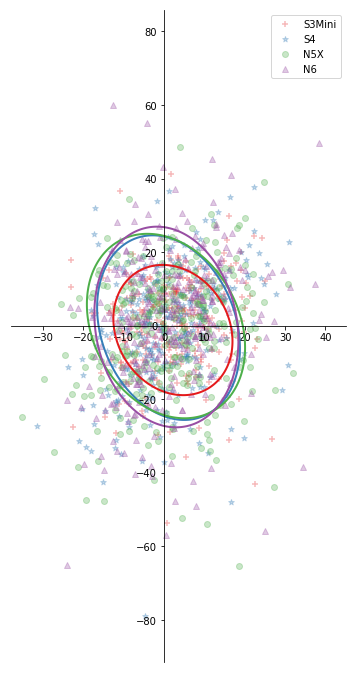

In [28]:
df_info["x_val"] = df_info.XPred - df_info.X
df_info["y_val"] = df_info.YPred - df_info.Y
df_info["x_val_mm"] = -1
df_info["y_val_mm"] = -1
for p in smartphones:
    df_info.loc[df_info.Phone == p, "x_val_mm"] = df_info.loc[df_info.Phone == p].x_val * get_screen_size(p)[2]
    df_info.loc[df_info.Phone == p, "y_val_mm"] = df_info.loc[df_info.Phone == p].y_val * get_screen_size(p)[2]
df_x = df_info[df_info.Set == "test"]

fig1, ax1 = plt.subplots(1, figsize=(6,12))
marker = ["+","*","o","^"]
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_position(('data',0))
ax1.spines['bottom'].set_position(('data',0))
#ax1.set_xticks(xticks[:])
#ax1.set_yticks(yticks[:])

for i, phone in enumerate(smartphones):
    smartphone_values = get_screen_size(phone)
    df_tmp = df_x[df_x.Phone == phone].sample(300)
    plt.scatter(df_tmp.x_val_mm, -df_tmp.y_val_mm, alpha = 0.3, marker = marker[i],c = colors[i], label = phone)
#     ell_width = abs(df_tmp.XErr.mean())+(abs(df_tmp.XErr.std())*2)
#     ell_heigth = abs(df_tmp.YErr.mean())+(abs(df_tmp.YErr.std())*2)
#     ell = mpatches.Ellipse((0,0), ell_width, ell_heigth, fill = False)#, color = colors[i])
#     ax1.add_patch(ell)
    X2 = df_x[df_x.Phone == phone][['x_val_mm', 'y_val_mm']].values

    clf = EllipticEnvelope(contamination=0.261)

    xx2, yy2 = np.meshgrid(np.linspace(X2[:, 0].min(), X2[:, 0].max(), 500), np.linspace(X2[:, 1].min(), X2[:, 1].max(), 500))
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    plt.contour(xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])


plt.legend()
plt.savefig("../../data/plots/ellipses_general.pdf", bbox_inches = "tight")